# ECE 276A: PR-1

In [1]:
import transforms3d

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
# from .autonotebook import tqdm as notebook_tqdm

/home/jd/anaconda3/envs/portal/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from utils.load_data import read_data
from utils.rotplot import rotplot

In [18]:
NUM_SCENES = 9
split = 'train'
SPLIT = 'trainset' if split == 'train' else 'testset'
SCENE = 1

In [19]:
cfile_path = "./data/{}/cam/cam{}.p"
ifile_path = "./data/{}/imu/imuRaw{}.p"
vfile_path = "./data/{}/vicon/viconRot{}.p"

# Sample Camera Data

In [20]:
cam_1 = read_data(cfile_path.format(SPLIT, SCENE))

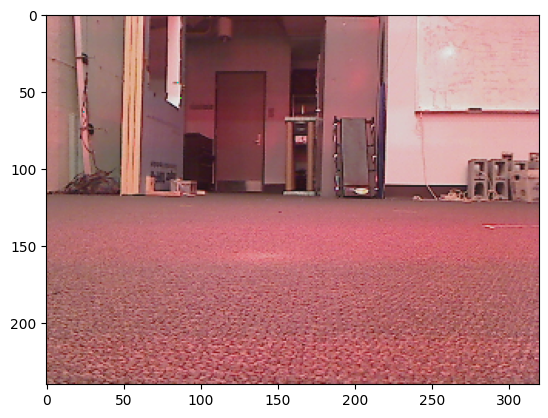

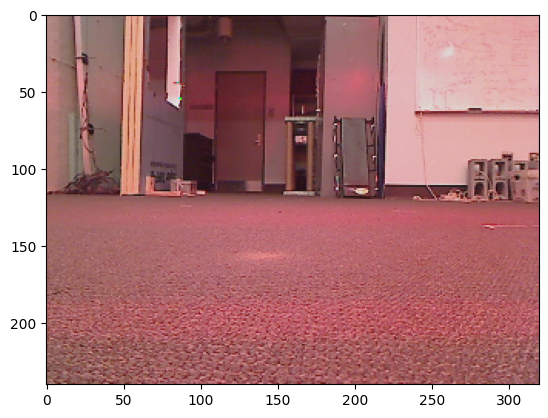

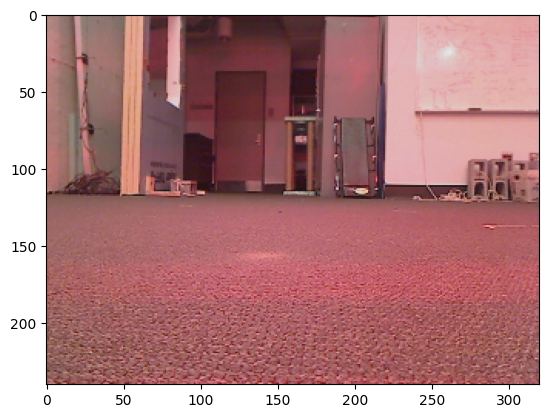

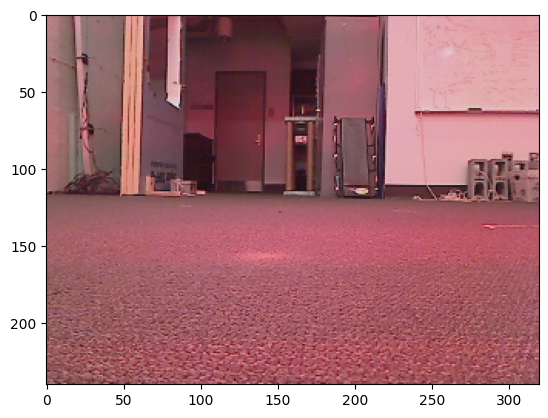

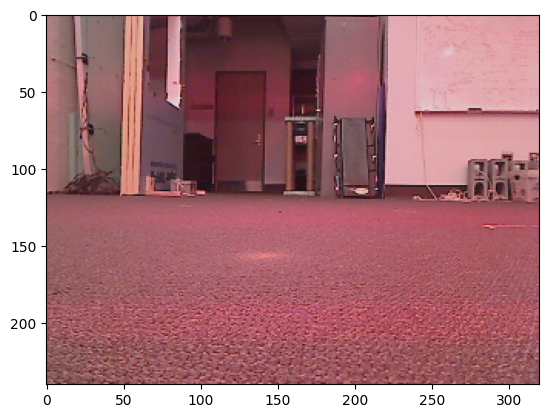

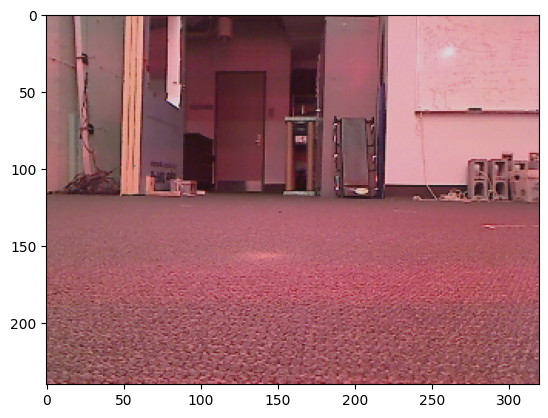

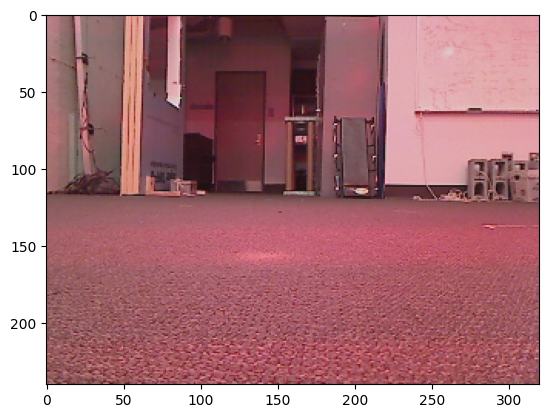

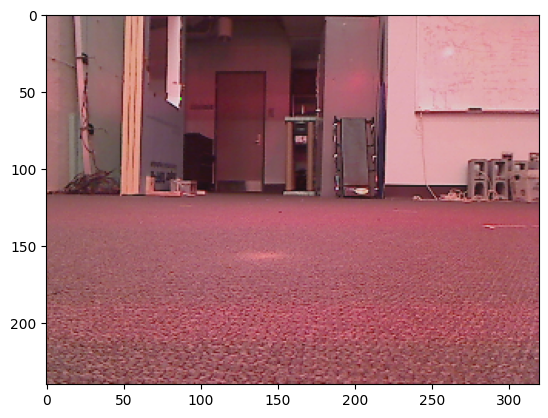

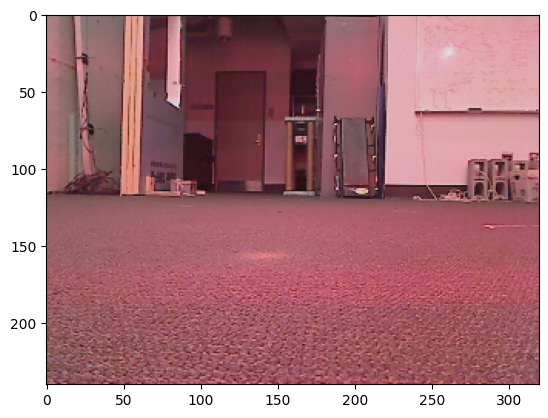

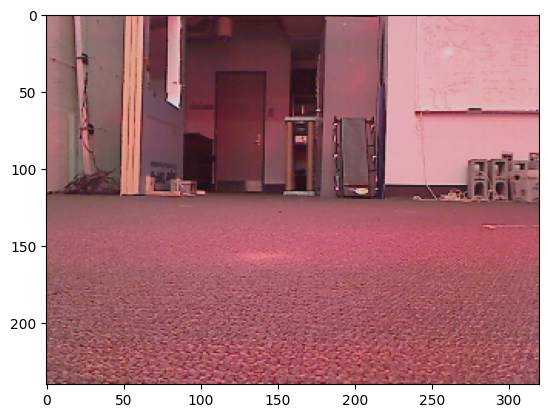

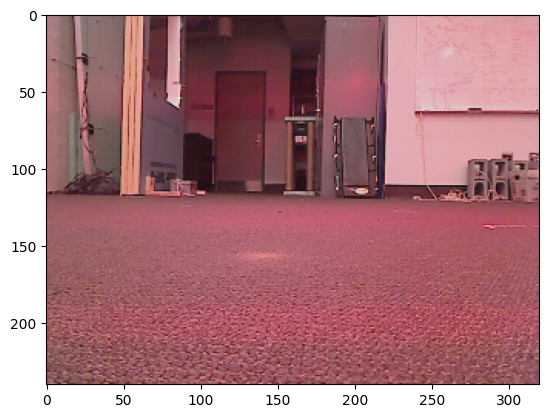

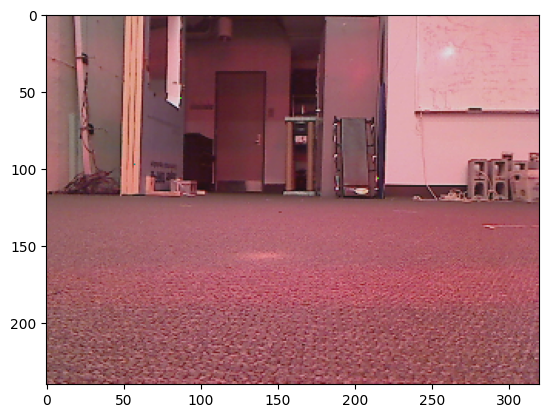

In [21]:
num_steps = cam_1['cam'].shape[-1]

for step in range(num_steps):
    img = cam_1['cam'][..., step]
    plt.imshow(img)
    plt.show()
    
    if step > 10:
        break

# Sample IMU Data

The imu values are:

$$A_x, A_y, A_z, W_z, W_x, W_y$$

Here, the $A$ values correspond to the accelerations along the axes (measuring the normal force), and the $Q$ values correspond to the rotation rates.

In [22]:
imu_1 = read_data(ifile_path.format(SPLIT, SCENE)) # 6, N

In [23]:
imu_length = imu_1['vals'].shape[1]

In [24]:
imu_1['vals']

array([[511, 511, 511, ..., 511, 511, 511],
       [501, 501, 501, ..., 500, 500, 500],
       [605, 605, 606, ..., 605, 605, 606],
       [370, 369, 370, ..., 369, 369, 369],
       [374, 373, 374, ..., 373, 374, 373],
       [376, 376, 375, ..., 375, 376, 375]], dtype=uint16)

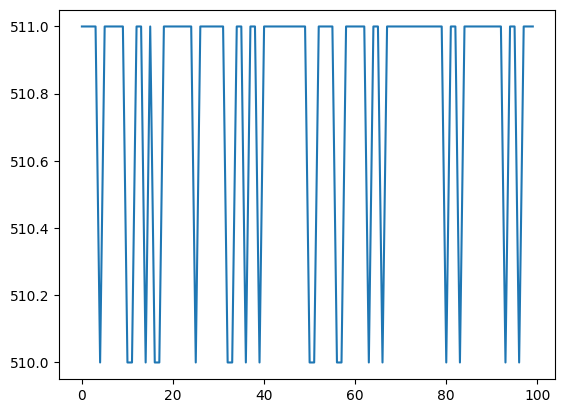

In [25]:
plt.plot(imu_1['vals'][0][:100])
plt.show()

# Plot Vicon Ground Truth

In [26]:
vicon_1 = read_data(vfile_path.format(SPLIT, SCENE)) # 3, 3, N

In [27]:
euler_gt = np.asarray(list(map(lambda x: transforms3d.euler.mat2euler(x), np.transpose(vicon_1['rots'], (2, 0, 1)))))

In [28]:
def plot_euler(euler_pred, euler_gt, ts_1, ts_2):
    fig = plt.figure(figsize=(15, 3))
    
    plt.plot(ts_1, euler_pred[:, 0], label="Predicted")
    plt.plot(ts_2, euler_gt[:, 0], label="Ground Truth")
    plt.title("Roll")
    plt.xlabel("Time")
    plt.ylabel("Rotation (Radians)")
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(15, 3))
    plt.plot(ts_1, euler_pred[:, 1], label="Predicted")
    plt.plot(ts_2, euler_gt[:, 1], label="Ground Truth")
    plt.title("Pitch")
    plt.xlabel("Time")
    plt.ylabel("Rotation (Radians)")
    plt.legend()
    plt.show()

    fig = plt.figure(figsize=(15, 3))
    plt.plot(ts_1, euler_pred[:, 2], label="Predicted")
    plt.plot(ts_2, euler_gt[:, 2], label="Ground Truth")
    plt.title("Yaw")
    plt.xlabel("Time")
    plt.ylabel("Rotation (Radians)")
    plt.legend()
    plt.show()

# Build quaternion functions

In [29]:
import jax

In [30]:
@jax.jit
def qlog(quaternion):
    
    quaternion = quaternion.at[:, 1:].set(quaternion[:, 1:] + 1e-3)
    
    a = jnp.log(jnp.linalg.norm(quaternion, axis=1))
    b = (quaternion[:, 1:]/jnp.linalg.norm(quaternion[:, 1:], axis=1)[:, None]) * jnp.arccos(quaternion[:, 0]/jnp.linalg.norm(quaternion, axis=1))[:, None]
    
    out = jnp.zeros((quaternion.shape))
    out = out.at[:, 0].set(a)
    out = out.at[:, 1:].set(b)
    
#     assert jnp.isnan(out).any() == False
    
    return out

@jax.jit
def qexp(quaternion):
    
    out = jnp.zeros(quaternion.shape)    
    out = out.at[:, 0].set(jnp.cos(jnp.linalg.norm(quaternion[:, 1:])))
    out = out.at[:, 1:].set(quaternion[:, 1:] * jnp.sin(jnp.linalg.norm(quaternion[:, 1:]))/jnp.linalg.norm(quaternion[:, 1:]))
    out = jnp.exp(quaternion[:, 0]) * out
#     assert jnp.isnan(out).any() == False
    
    return out

@jax.jit
def qmult(q_a, q_b):
    
    out = jnp.zeros(q_a.shape)
    a = q_a[:, 0] * q_b[:, 0] - jnp.sum(q_a[:, 1:] * q_b[:, 1:], axis=1)
    out = out.at[:, 0].set(a.flatten())
    out = out.at[:, 1:].set(q_a[:, 0][:, None] * q_b[:, 1:] + q_b[:, 0][:, None] * q_a[:, 1:] + jnp.cross(q_a[:, 1:], q_b[:, 1:]))

#     assert jnp.isnan(out).any() == False
    
    return out

@jax.jit
def qinv(quaternion):
    quaternion = quaternion.at[:, 1:].set(quaternion[:, 1:] + 1e-3)
    
    quaternion_inv = quaternion
    quaternion_inv = quaternion_inv.at[:, 1:].set(quaternion_inv[:, 1:] * -1)
    out = quaternion_inv/qnorm(quaternion_inv)[:, None]
#     assert jnp.isnan(out).any() == False
    
    return out

@jax.jit
def qnorm(quaternion):
    return jnp.linalg.norm(quaternion, axis=1) + 1e-3

# Calibrate

In [31]:
import jax
import copy
from tqdm.auto import tqdm

In [32]:
from jax.config import config
config.update("jax_debug_nans", False)
config.update("jax_enable_x64", True)

In [33]:
import jax.numpy as jnp

In [34]:
def rot2quaternion(R):
    w = 0.5 * jnp.sqrt(1 + R[0][0] + R[1][1] + R[2][2])
    x = (R[2][1] - R[1][2]) / (4 * w)
    y = (R[0][2] - R[2][0]) / (4 * w)
    z = (R[1][0] - R[0][1]) / (4 * w)
    return jnp.array([w, x, y, z])

def quat2rot(q):

    q = q / np.linalg.norm(q)
    R = np.zeros((3, 3))
    R[0][0] = 2 * q[0] ** 2 + 2 * q[1] ** 2 - 1
    R[0][1] = 2 * q[1] * q[2] - 2 * q[0] * q[3]
    R[0][2] = 2 * q[1] * q[3] + 2 * q[0] * q[2]
    R[1][0] = 2 * q[1] * q[2] + 2 * q[0] * q[3]
    R[1][1] = 2 * q[0] ** 2 + 2 * q[2] ** 2 - 1
    R[1][2] = 2 * q[2] * q[3] - 2 * q[0] * q[1]
    R[2][0] = 2 * q[1] * q[3] - 2 * q[0] * q[2]
    R[2][1] = 2 * q[2] * q[3] + 2 * q[0] * q[1]
    R[2][2] = 2 * q[0] ** 2 + 2 * q[3] ** 2 - 1

    return R

In [35]:
bias = np.sum(imu_1['vals'][:, :100], axis=1) / 100
bias = bias.reshape(-1, 1)

Calibrate Angular Velocity

In [36]:
value = np.zeros_like(imu_1['vals'], dtype=np.float64)

In [37]:
sensitivity = 3.33
scale_factor = 3300.0 / 1023 * np.pi / 180 / sensitivity
value[-3:] = (imu_1['vals'][-3:] - bias[-3:]) * scale_factor

Calibrate Acceleration

In [38]:
sensitivity = 300
scale_factor = 3300 / (1023 * sensitivity) * 9.8
value[:2] = (imu_1['vals'][:2] - bias[:2]) * scale_factor
value[2, :] = (imu_1['vals'][2, :] - bias[2, :]) * -scale_factor - 9.8

In [39]:
value[[3, 4, 5]] = value[[4, 5, 3]]

In [40]:
rots = []

In [41]:
qs = [
    jnp.array([1, 0, 0, 0])
]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Motion Model

In [42]:
# From Time 1 to T-1
for i in tqdm(range(0, imu_length-1)):
    ts = imu_1['ts'][0][i+1] - imu_1['ts'][0][i]
    angular_velocity = jnp.expand_dims(value[-3:][:, i+1], 0)
        
#     angular_velocity = jnp.array([angular_velocity[1], angular_velocity[2], angular_velocity[0]])
    temp = jnp.zeros((1, 4))
    temp = temp.at[:, 0].set(0)
    temp = temp.at[:, 1:].set(ts * angular_velocity / 2)

    a = temp[:, 0] + temp[:, 1:] @ temp[:, 1:].T    
    q_t = qmult(jnp.expand_dims(qs[-1], 0), qexp(temp))[0]
    rot = quat2rot(q_t)
    
    qs.append(q_t)
    rots.append(rot)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5644/5644 [07:06<00:00, 13.23it/s]


In [43]:
qs = jnp.array(qs)

In [44]:
euler_pred = np.asarray(list(map(lambda x: transforms3d.euler.mat2euler(x), rots)))

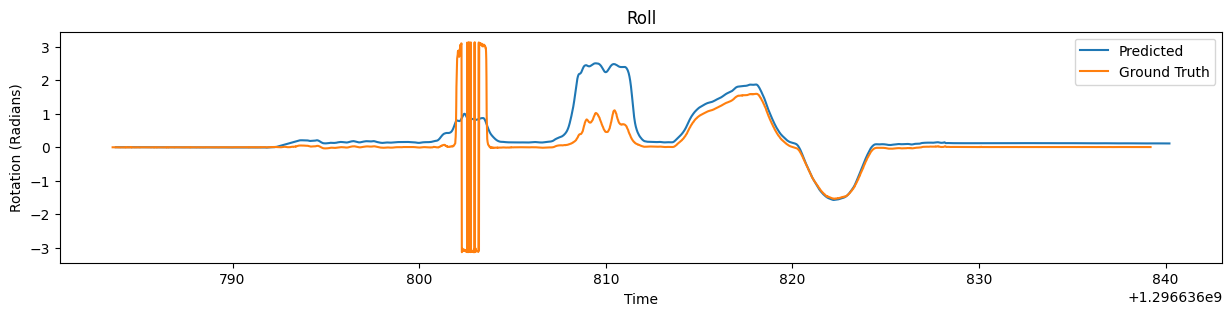

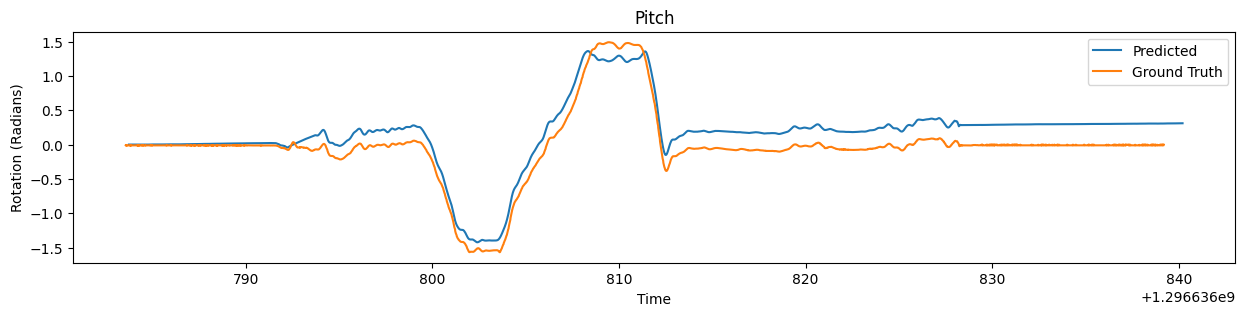

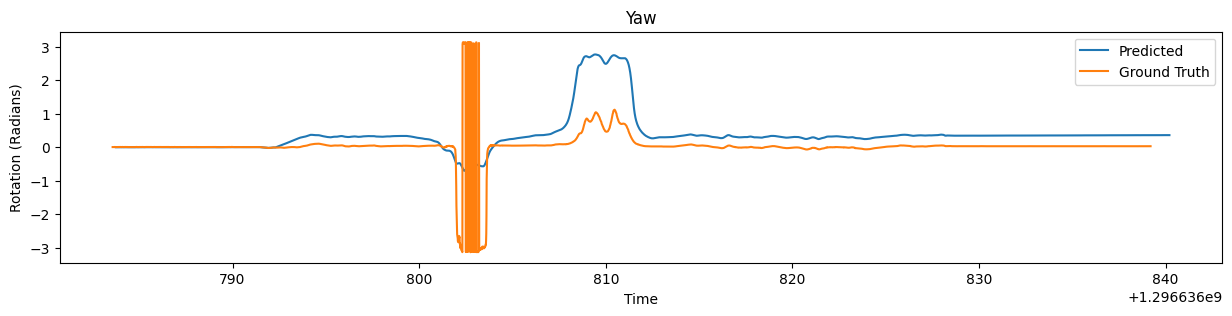

In [45]:
plot_euler(euler_pred, euler_gt, imu_1['ts'][0][1:], vicon_1['ts'][0])

# Plot Initial vs IMU  - Observation Model

In [46]:
g = jnp.zeros((qs.shape[0], 4))
g = g.at[:, -1].set(-9.8)

In [47]:
# From time 1 to T
predicted_acceleration = []

for i in tqdm(range(len(qs))):   
    
    a = qmult(qinv(qs[i][None, :]), qmult(g[0][None, :], qs[i][None, :]))
    
    predicted_acceleration.append(a[0])
predicted_acceleration = np.array(predicted_acceleration)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5645/5645 [00:59<00:00, 94.38it/s]


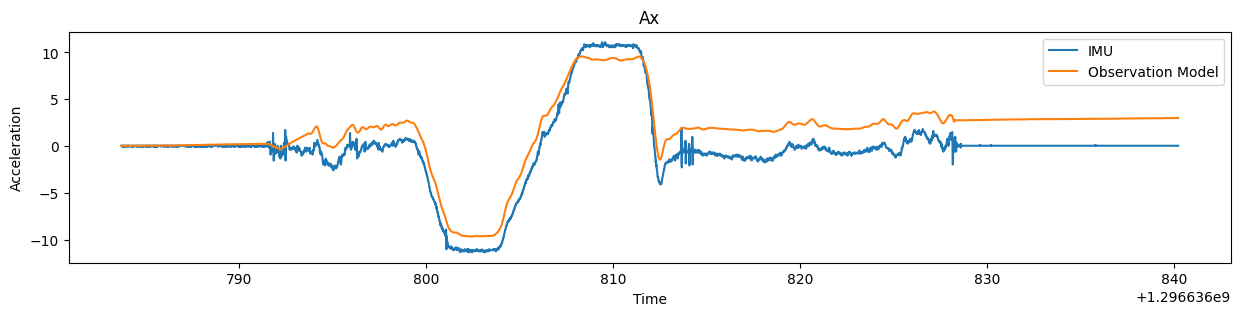

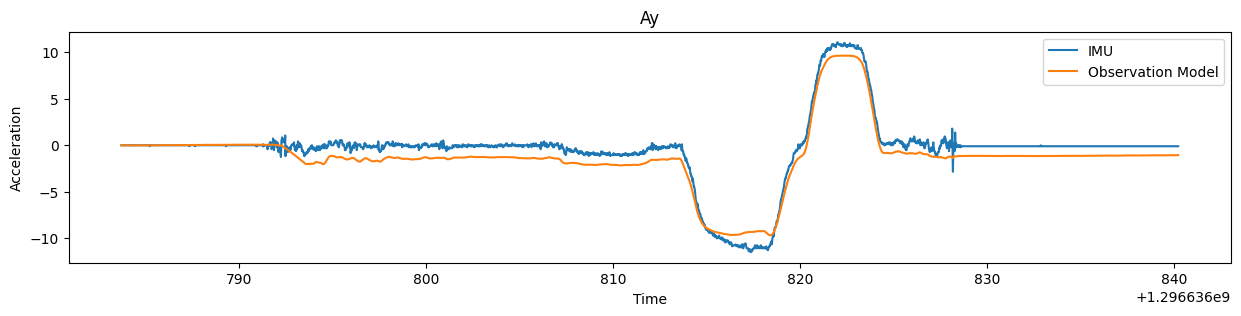

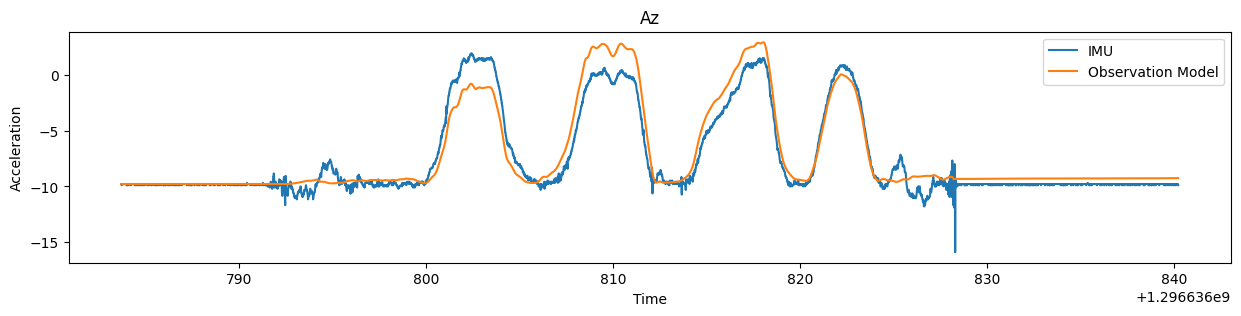

In [49]:
fig = plt.figure(figsize=(15, 3))
plt.plot(imu_1['ts'][0], value[0, :], label="IMU")
plt.plot(imu_1['ts'][0], predicted_acceleration[:, 1], label="Observation Model")
plt.title("Ax")
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.show()

fig = plt.figure(figsize=(15, 3))
plt.plot(imu_1['ts'][0], value[1, :], label="IMU")
plt.plot(imu_1['ts'][0], predicted_acceleration[:, 2], label="Observation Model")
plt.title("Ay")
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.show()

fig = plt.figure(figsize=(15, 3))
plt.plot(imu_1['ts'][0], value[2, :], label="IMU")
plt.plot(imu_1['ts'][0], predicted_acceleration[:, 3], label="Observation Model")
plt.title("Az")
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.legend()
plt.show()

Predicted and GT acceleration should correspond

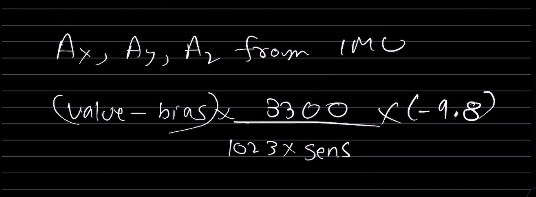

# Optimisation

In [50]:
accelerations = jnp.array(value[:3]).T

In [51]:
def cost_calc(x):
    a = jnp.linalg.norm(2 * qlog(qmult(qinv(x[2:]), x[1:-1])))
    b = jnp.linalg.norm(accelerations[1:] - qmult(qinv(x[1:]), qmult(g[1:], x[1:]))[:, 1:])
    assert a != np.nan
    assert b != np.nan
    cost = (a + 0.5 * b) * 0.5
    return cost

https://piazza.com/class/lch5ars4s191lo/post/103

In [52]:
var = jnp.array(copy.deepcopy(qs))

  0%|                                                                                                                                               | 0/500 [00:00<?, ?it/s]

Iteration 0, Loss: 51.48214463759263
0.42139321054267254 205.08579212928518


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:19<00:00,  6.32it/s]


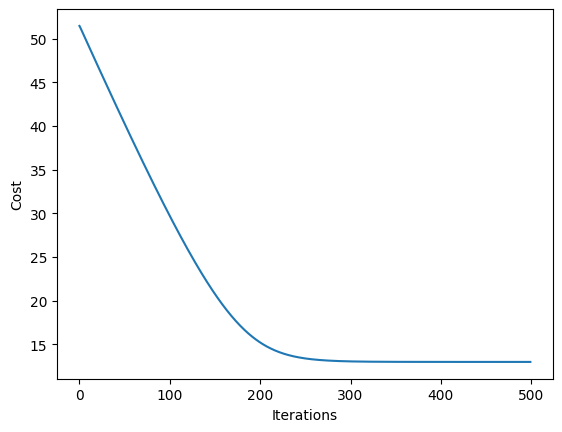

In [56]:
ALPHA = 0.01
dcdq = jax.grad(cost_calc)

prev_cost_diff = []
costs = []

for i in tqdm(range(500)):
    cost = cost_calc(var)
    costs.append(cost)
    
#     if np.mean(prev_cost_diff)
    
    if i % 1000 == 0:
        print(f"Iteration {i}, Loss: {cost}")
        x = var
        print(jnp.linalg.norm(2 * qlog(qmult(qinv(x[2:]), x[1:-1]))), jnp.linalg.norm(accelerations[1:] - qmult(qinv(x[1:]), qmult(g[1:], x[1:]))[:, 1:]))

#         plot_euler(euler_new[1:], euler_gt, imu_1['ts'][0][1:], vicon_1['ts'][0])
    
    grad = dcdq(var)    
    var = (var - ALPHA * grad) / (jnp.linalg.norm(var - ALPHA * grad, axis=1)[:, None] + 1e-3)

# Rs = list(map(lambda x: quat2rot(x), var))
# euler_new = np.asarray(list(map(lambda x: transforms3d.euler.mat2euler(x), Rs)))    
# plot_euler(euler_new[1:], euler_gt, imu_1['ts'][0][1:], vicon_1['ts'][0])
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()